# <div align="center">Kaggle Competition</div>
### <div align="center">Business Data Science</div>
## <div align="center">Submitted by Subhayu Chakravarty</div>

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, Lasso
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, recall_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA

from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier, BalancedRandomForestClassifier
import time

from sklearn.feature_selection import RFE, RFECV
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import lightgbm as lgb

Using TensorFlow backend.
/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Data Reading and Exploratory Analysis

In [3]:
df=pd.read_csv('train_final.csv')
test=pd.read_csv('test_final.csv')
df.head()

,Id,Y,f1,f2,f3,f4,f5,f6,f7,f8,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,1,1,25884,1,33.63,118596,1,0,118595,125738,...,1945,118450,119184,1,121372,1,1,1,2,1
1,2,1,34346,1,10.62,118041,1,0,117902,130913,...,15385,117945,292795,1,259173,1,1,1,1,1
2,3,1,34923,1,1.77,118327,1,0,117961,124402,...,7547,118933,290919,1,118784,1,1,1,1,1
3,4,1,80926,1,30.09,118300,1,0,117961,301218,...,4933,118458,118331,1,307024,1,1,1,2,1
4,5,1,4674,1,1.77,119921,1,0,119920,302830,...,13836,142145,4673,1,128230,1,1,1,620,1


In [4]:
test.shape

(16385, 25)

[1 0]
Y=1:  15435  - Percent:  0.94
Y=0:  948  - Percent:  0.06


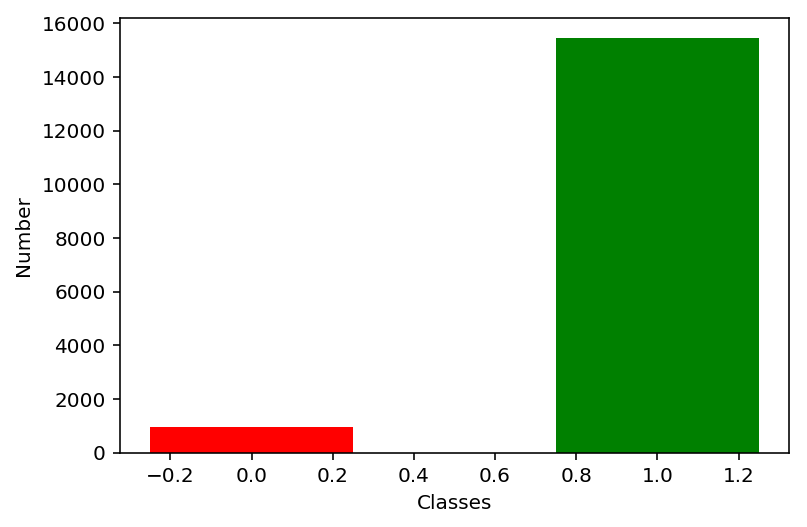

In [5]:
# Percentage distribution of classes
print(df['Y'].unique())

print("Y=1: ",df[df['Y']==1].count()[0]," - Percent: ", round(df[df['Y']==1].count()[0]/df.count()[0],2))
print("Y=0: ",df[df['Y']==0].count()[0]," - Percent: ", round(df[df['Y']==0].count()[0]/df.count()[0],2))

plt.bar(0,df[df['Y']==0].count()[0],.5,color='r')
plt.bar(1,df[df['Y']==1].count()[0],.5,color='g')
plt.ylabel('Number')
plt.xlabel('Classes')
plt.savefig('class_dist.png')
plt.show()

In [6]:
# Checking presence of null values
df.isnull().sum()

Id     0
Y      0
f1     0
f2     0
f3     0
f4     0
f5     0
f6     0
f7     0
f8     0
f9     0
f10    0
f11    0
f12    0
f13    0
f14    0
f15    0
f16    0
f17    0
f18    0
f19    0
f20    0
f21    0
f22    0
f23    0
f24    0
dtype: int64

In [6]:
# Getting mean and other statistics of each column
df.describe()

,Id,Y,f1,f2,f3,f4,f5,f6,f7,f8,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
count,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,...,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,16383.000000,1.638300e+04,16383.000000
mean,8192.000000,0.942135,43007.775865,1.044375,11.770938,118323.581456,1.044436,0.050052,117089.674113,169730.178600,...,25894.316914,119045.099005,184622.040835,1.047305,125959.667765,1.044558,1.045718,1.041934,3.271890e+04,1.043948
std,4729.509065,0.233495,33611.182771,0.264806,353.187115,4518.059755,0.265601,0.293892,10261.292970,69396.677853,...,36086.993946,18321.987129,100590.811845,0.306239,31091.344158,0.262576,0.266874,0.246597,3.184929e+06,0.259640
min,1.000000,0.000000,-1.000000,1.000000,1.770000,23779.000000,1.000000,0.000000,4292.000000,4673.000000,...,25.000000,4674.000000,3130.000000,1.000000,117879.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
25%,4096.500000,1.000000,20311.000000,1.000000,1.770000,118096.000000,1.000000,0.000000,117961.000000,117906.000000,...,4554.000000,118395.000000,118398.000000,1.000000,118274.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000
50%,8192.000000,1.000000,35527.000000,1.000000,1.770000,118300.000000,1.000000,0.000000,117961.000000,128130.000000,...,13234.000000,118929.000000,119095.000000,1.000000,118568.000000,1.000000,1.000000,1.000000,2.000000e+00,1.000000
75%,12287.500000,1.000000,74240.500000,1.000000,3.540000,118386.000000,1.000000,0.000000,117961.000000,234498.500000,...,38902.000000,120539.000000,290919.000000,1.000000,120006.000000,1.000000,1.000000,1.000000,9.000000e+00,1.000000
max,16383.000000,1.000000,312152.000000,7.000000,43910.160000,286791.000000,9.000000,10.000000,311178.000000,311867.000000,...,311696.000000,286792.000000,308574.000000,18.000000,311867.000000,8.000000,8.000000,7.000000,4.042886e+08,8.000000


In [8]:
# Unique values in each column
for i in df.columns:
    if i not in ['Id','Y']:
        print(i," : ", df[i].unique())
  

f1  :  [25884 34346 34923 ... 43426 34326  6706]
f2  :  [1 2 4 3 5 6 7]
f3  :  [3.363000e+01 1.062000e+01 1.770000e+00 3.009000e+01 3.540000e+00
 2.301000e+01 5.310000e+00 1.770000e+01 3.540000e+01 2.832000e+02
 7.080000e+00 8.850000e+00 1.823100e+02 2.655000e+01 8.319000e+01
 4.796700e+02 1.593000e+01 1.947000e+01 7.257000e+01 1.416000e+01
 1.239000e+01 2.832000e+01 4.071000e+01 2.478000e+01 2.513400e+02
 7.611000e+01 5.664000e+01 1.221300e+02 1.185900e+02 3.894000e+01
 2.124000e+01 6.372000e+01 1.062000e+02 4.425000e+01 3.186000e+01
 5.133000e+01 2.301000e+02 1.150500e+02 3.327600e+02 8.142000e+01
 6.903000e+01 3.717000e+01 4.779000e+01 6.018000e+01 4.956000e+01
 3.486900e+02 6.761400e+02 1.283250e+03 6.726000e+01 3.150600e+02
 3.752400e+02 6.549000e+01 1.097400e+02 1.274400e+02 1.522200e+02
 5.398500e+02 1.239000e+02 9.381000e+01 1.309800e+02 8.460600e+02
 2.230200e+02 3.433800e+02 1.840800e+02 1.451400e+02 7.080000e+01
 5.841000e+01 4.060380e+03 5.487000e+01 8.496000e+01 9.558000e+

#### Candidates for one-hot encoding : f2, f5, f6, f9, f11, f18, f20, f21, f22, f24

In [9]:
for i in ['f2', 'f5', 'f6', 'f9', 'f11', 'f18', 'f20', 'f21', 'f22', 'f24']:
    if i not in ['Id','Y']:
        print(i," : ", df[i].unique())

# In Test Data Set:
# f2  :  [1 2 4 3 5 6 7]
# f5  :  [1 2 3 5 6 7 4 9]
# f6  :  [ 0  2  1  3  5 10  8  4  6]
# f9  :  [ 1  2  3  4  5 11  7]
# f11  :  [1 2 3 4 5 6 8]
# f18  :  [ 1  2  4  3 11  5  6  7 18]
# f20  :  [1 3 2 5 4 8 7]
# f21  :  [1 4 2 3 5 6 8 7]
# f22  :  [1 3 2 5 4 7 6]
# f24  :  [1 2 4 3 6 5 8]

f2  :  [1 2 4 3 5 6 7]
f5  :  [1 2 3 5 6 7 4 9]
f6  :  [ 0  2  1  3  5 10  8  4  6]
f9  :  [ 1  2  3  4  5 11  7]
f11  :  [1 2 3 4 5 6 8]
f18  :  [ 1  2  4  3 11  5  6  7 18]
f20  :  [1 3 2 5 4 8 7]
f21  :  [1 4 2 3 5 6 8 7]
f22  :  [1 3 2 5 4 7 6]
f24  :  [1 2 4 3 6 5 8]


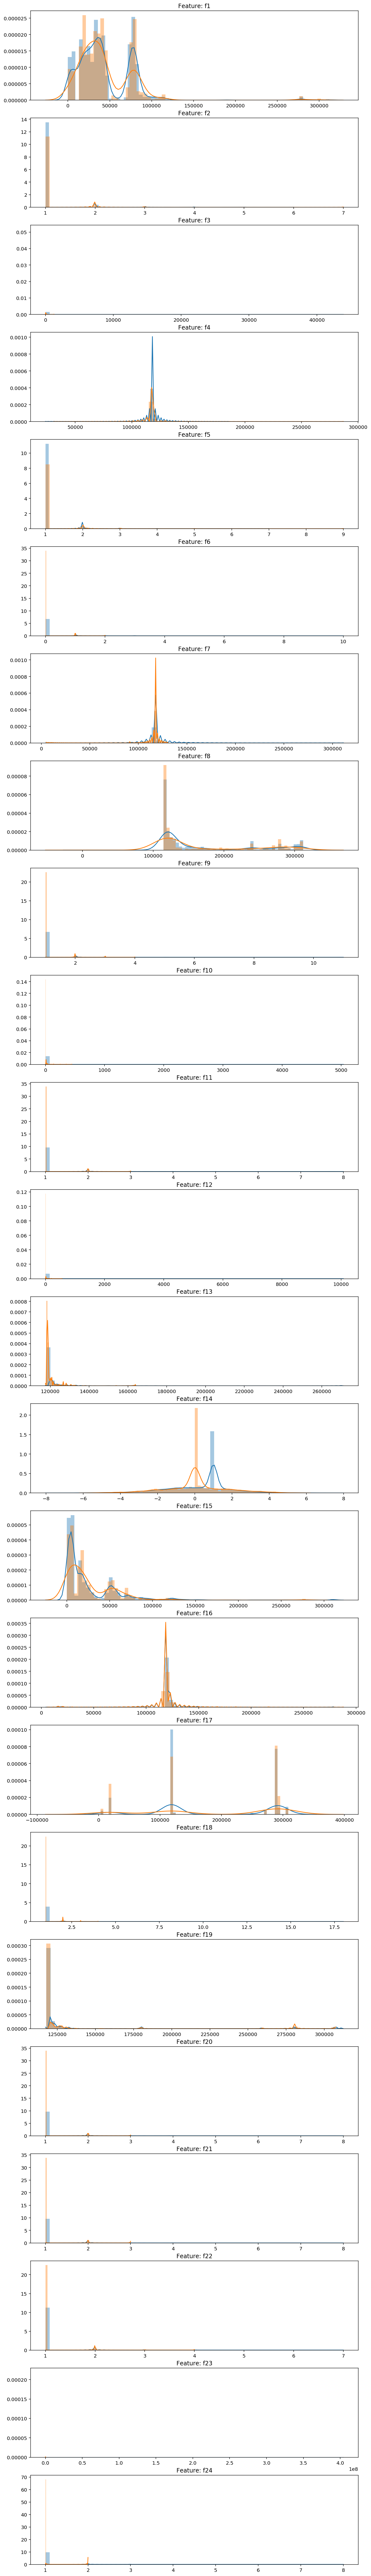

In [11]:
# Correlated Features : To check if features vary between the classes
plt.figure(figsize=(12,24*4))

features = df.iloc[:,2:].columns
gs = gridspec.GridSpec(24, 1)
for i, feature in enumerate(df[features]):
    ax = plt.subplot(gs[i])
    sns.distplot(df[feature][df.Y == 1], bins=70)
    sns.distplot(df[feature][df.Y == 0], bins=70)
    ax.set_xlabel('')
    ax.set_title('Feature: ' + str(feature))
plt.show()

Above plots show similar distributions of the features between the classes, except f1,f6 and f14. 
Such features generally do not contribute to the model.

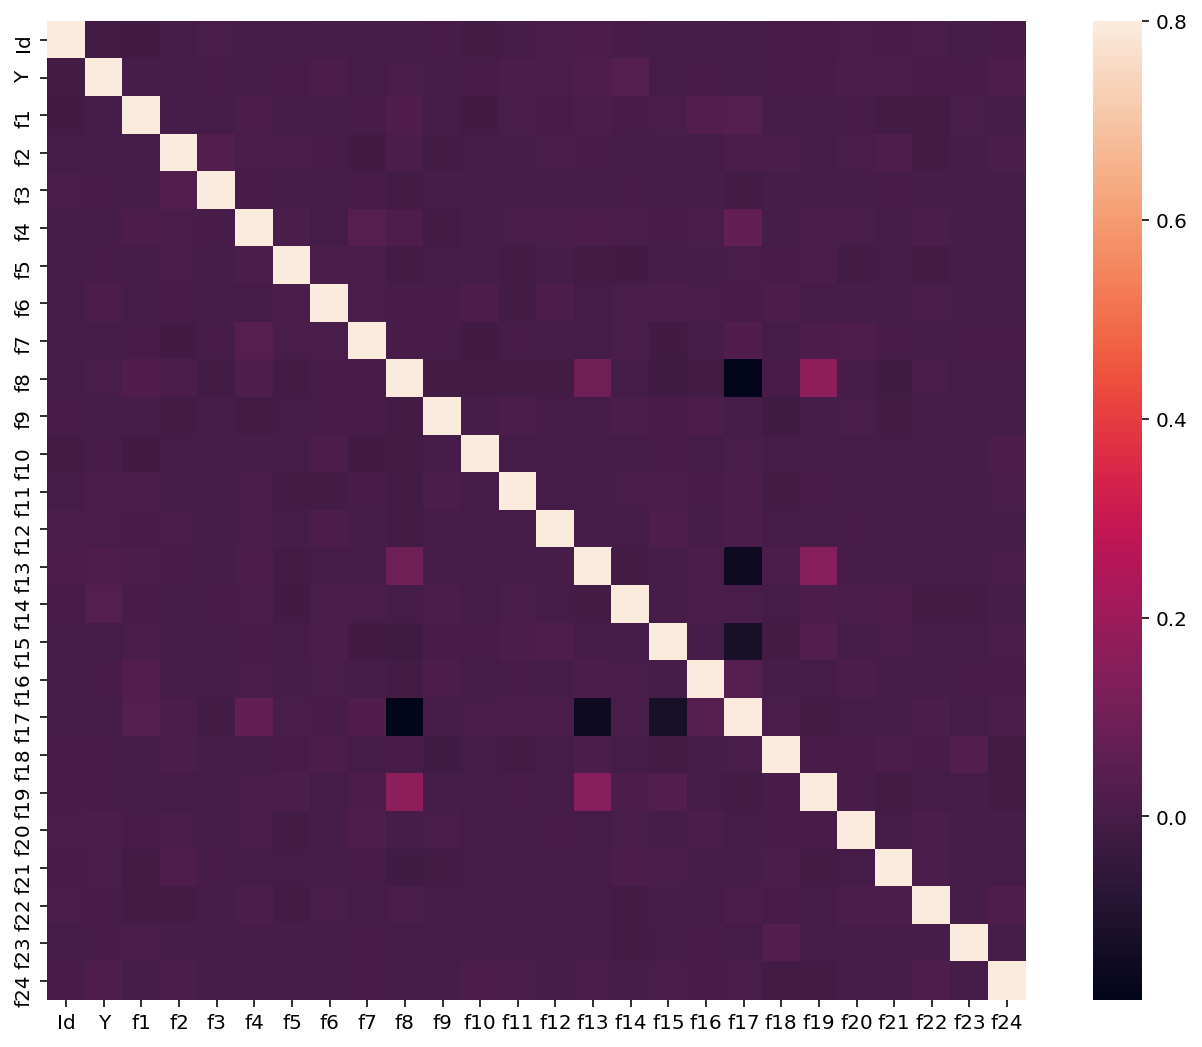

In [111]:
# Correlation Matrix
corrmat = df.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.savefig('heatmap.png')

#### Candidates for interaction terms : (f8,f19), (f8,f13), (f8,f17), (f13,f19), (f13,f17), (f15,f17)

In [12]:
# Feature correlation with Label Y :
dfcorr=df.corr().iloc[1]
dfcorr

Id    -0.009178
Y      1.000000
f1    -0.000444
f2    -0.000920
f3     0.002483
f4    -0.000037
f5     0.003077
f6     0.015522
f7    -0.006114
f8     0.005902
f9    -0.000367
f10    0.003834
f11    0.008494
f12    0.005068
f13    0.017812
f14    0.031292
f15   -0.003840
f16    0.002596
f17   -0.006608
f18    0.001575
f19    0.000933
f20    0.011192
f21    0.004252
f22    0.001859
f23    0.002507
f24    0.016778
Name: Y, dtype: float64

In [16]:
# Highest correlation with Label : 
for i in range(len(dfcorr)):
    if (dfcorr[i]>0.005 or dfcorr[i]<-0.005) and dfcorr[i]!=1.0 and dfcorr.index[i]!='Id':
        print(dfcorr.index[i]," : ",dfcorr[i])

f6  :  0.01552182166866531
f7  :  -0.006114070369900142
f8  :  0.005902006621468229
f11  :  0.008493783758324205
f12  :  0.005067647921095408
f13  :  0.017811817756622775
f14  :  0.031292224261526703
f17  :  -0.006608258022105977
f20  :  0.011192311915966785
f24  :  0.016777596732320665


## Pre-Model Analysis

In [44]:
# Standardizing features
def standardizeX(X):
    sc=StandardScaler()
    sc.fit(X)
    x_std=sc.transform(X)
    return x_std

In [45]:
# Setting X as feature matrix and Y as label
X=df.iloc[:,2:]
Y=df.iloc[:,1]

X_ohe=pd.get_dummies(X, columns=['f2', 'f5', 'f6', 'f9', 'f11', 'f18', 'f20', 'f21', 'f22', 'f24'])

In [46]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=7)

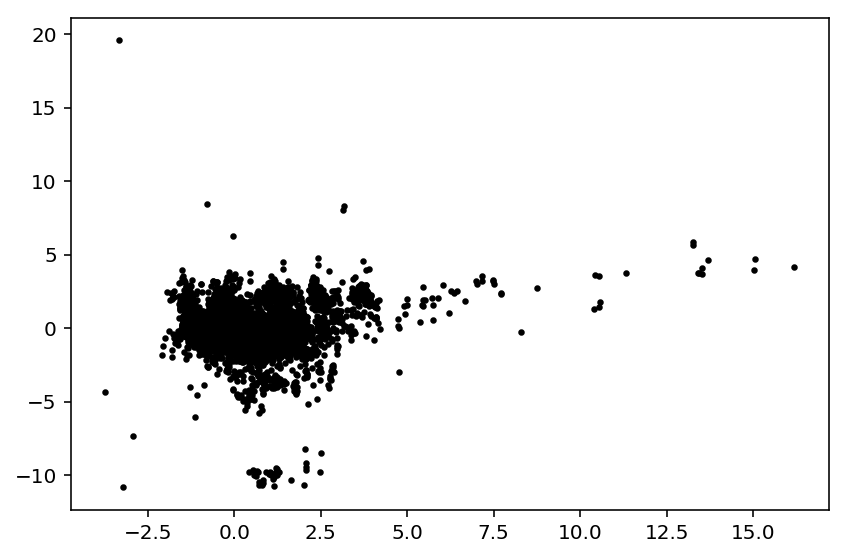

In [47]:
# Applying PCA to get Principal components
pca = PCA()
x_std=standardizeX(X)
X_pca = pca.fit_transform(x_std)

# Creating Scatter plot of data points for top two Principal Components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='black', marker='o', s=5)
plt.tight_layout()
plt.savefig('1-pca-data.png', dpi=30)
plt.show()

In [49]:
kmeans = KMeans(n_clusters=2,
            init='random',
            n_init=10,
            max_iter=500,
            tol=1e-04,
            random_state=9).fit(X_pca)

# Predicted Y
ypred=kmeans.predict(X_pca)
ypred

array([0, 1, 1, ..., 1, 1, 0], dtype=int32)

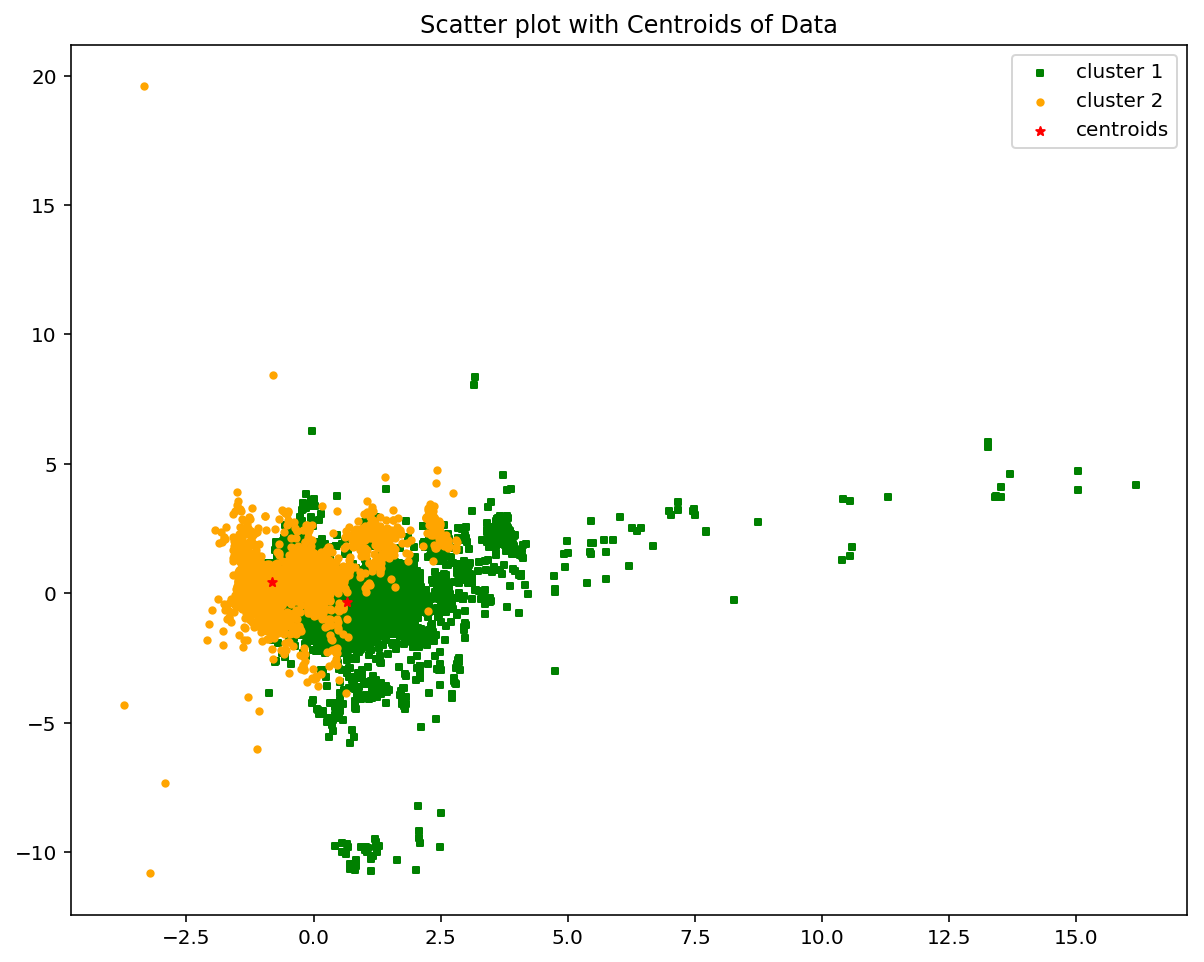

In [53]:
plt.figure(figsize=(10,8))

plt.scatter(X_pca[ypred == 0, 0],
            X_pca[ypred == 0, 1],
            s=10,
            c='green',
            marker='s',
            label='cluster 1')
plt.scatter(X_pca[ypred == 1, 0],
            X_pca[ypred == 1, 1],
            s=10,
            c='orange',
            marker='o',
            label='cluster 2')
plt.scatter(kmeans.cluster_centers_[:, 0],
            kmeans.cluster_centers_[:, 1],
            s=20,
            marker='*',
            c='red',
            label='centroids')

plt.title("Scatter plot with Centroids of Data")
plt.legend()
plt.show()

## Feature Analysis

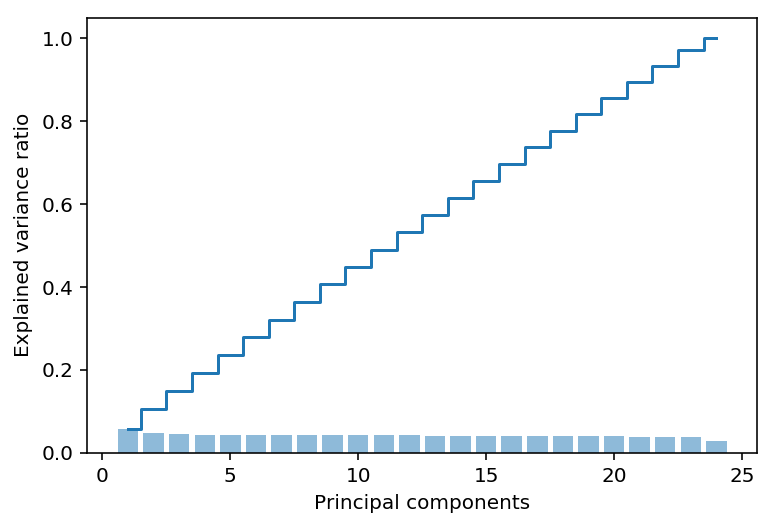

array([0.05800654, 0.04667111, 0.04427232, 0.04332447, 0.04320831,
       0.04301499, 0.04270112, 0.04260588, 0.04242958, 0.04204312,
       0.0417642 , 0.04163122, 0.04128033, 0.0411966 , 0.04103531,
       0.04082306, 0.04066416, 0.04037782, 0.04018377, 0.03987626,
       0.03875128, 0.03850756, 0.0374896 , 0.02814139])

In [112]:
# Plotting explained variance graph to show most important features
plt.bar(range(1, 25), pca.explained_variance_ratio_, alpha=0.5, align='center')
plt.step(range(1, 25), np.cumsum(pca.explained_variance_ratio_), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.savefig('exp-variance.png')
plt.show()

pca.explained_variance_ratio_

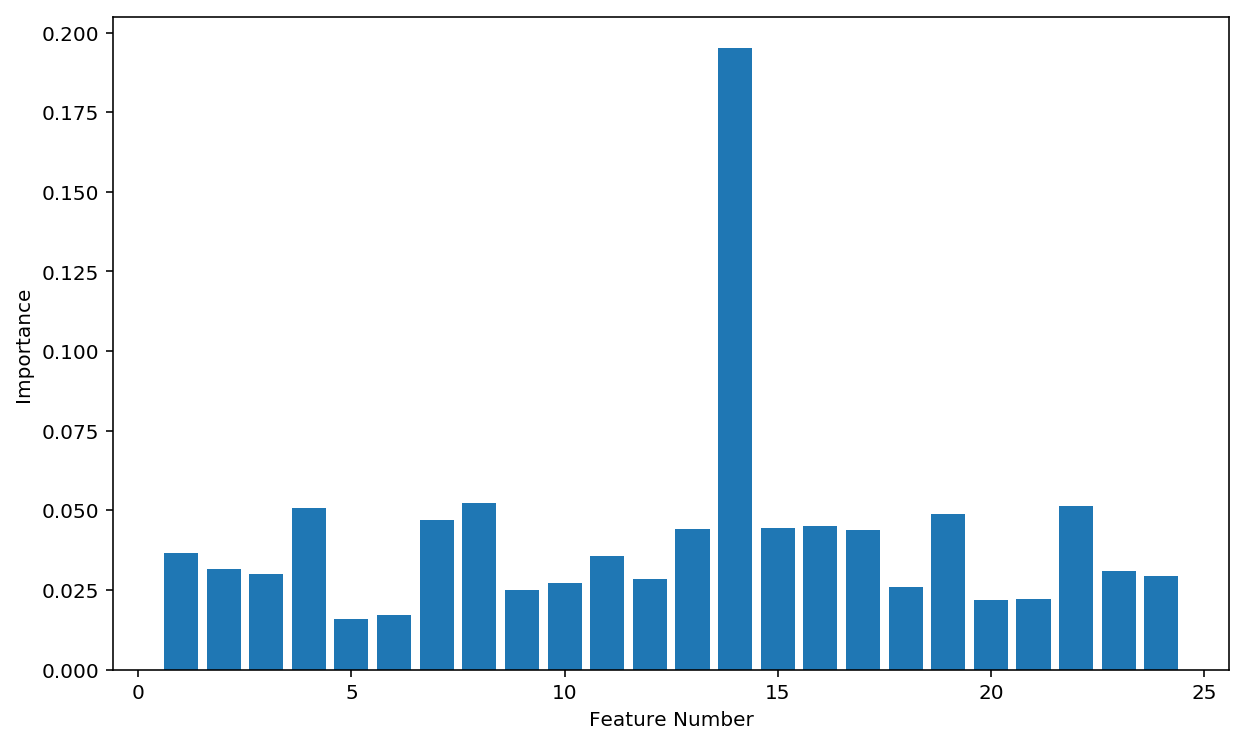

In [120]:
l1=XGBClassifier(learning_rate=0.13,n_estimators=500,max_depth=4, base_score=0.8, eval_metric='auc')
l1.fit(X,Y)
plt.figure(figsize=(10,6))
plt.bar(range(1,len(l1.feature_importances_)+1), l1.feature_importances_)
plt.xlabel("Feature Number")
plt.ylabel("Importance")
plt
plt.show()

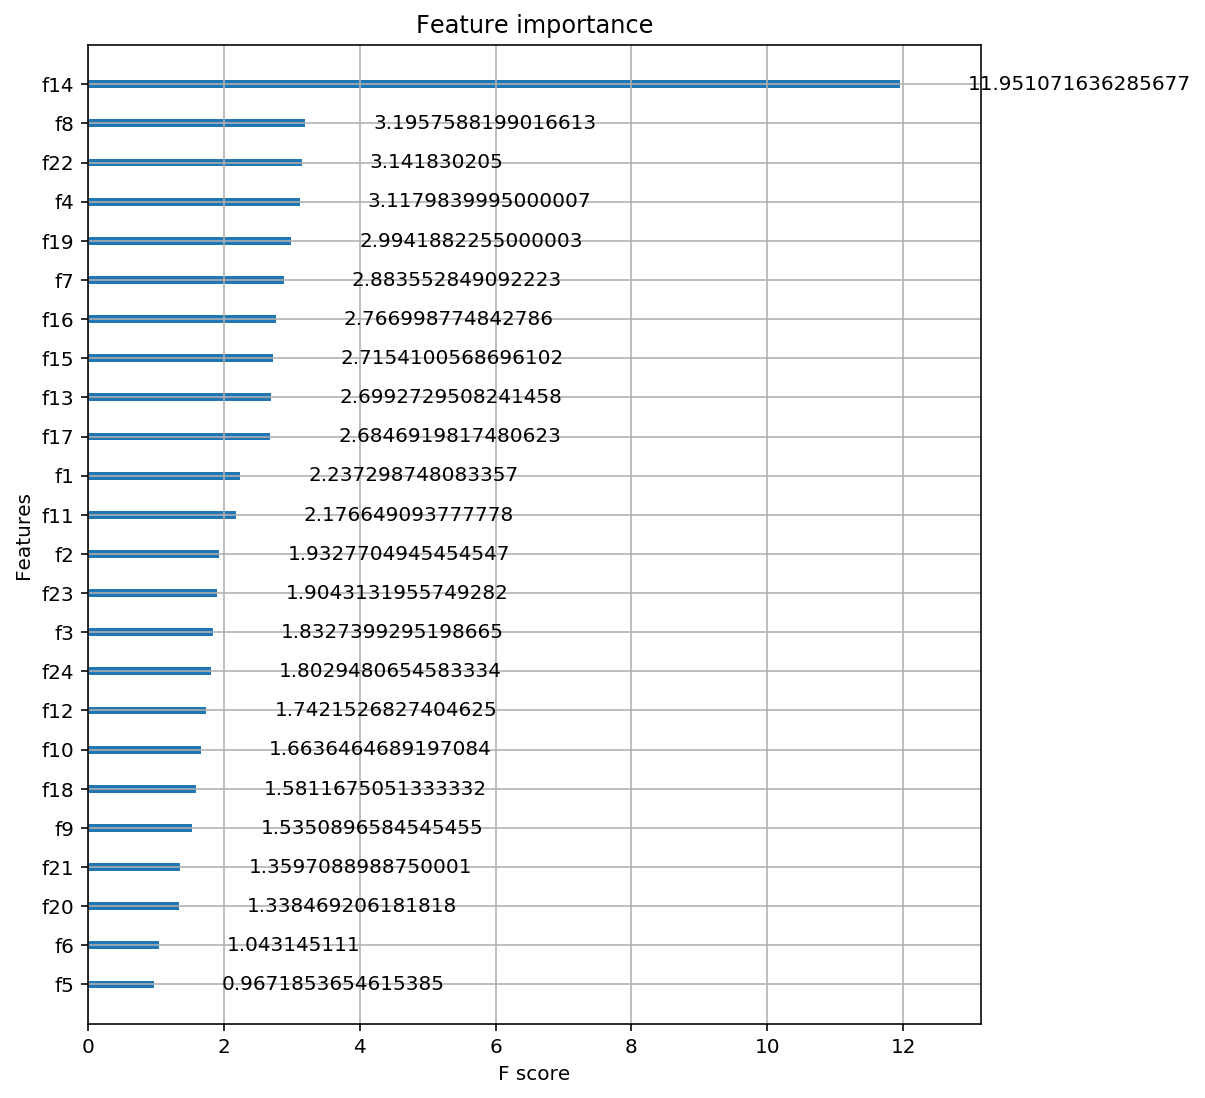

In [121]:
# Feature importance as per XGBoost
import xgboost as xgb

ax = xgb.plot_importance(l1, importance_type='gain',max_num_features=50) 
fig = ax.figure
fig.set_size_inches(8, 9)

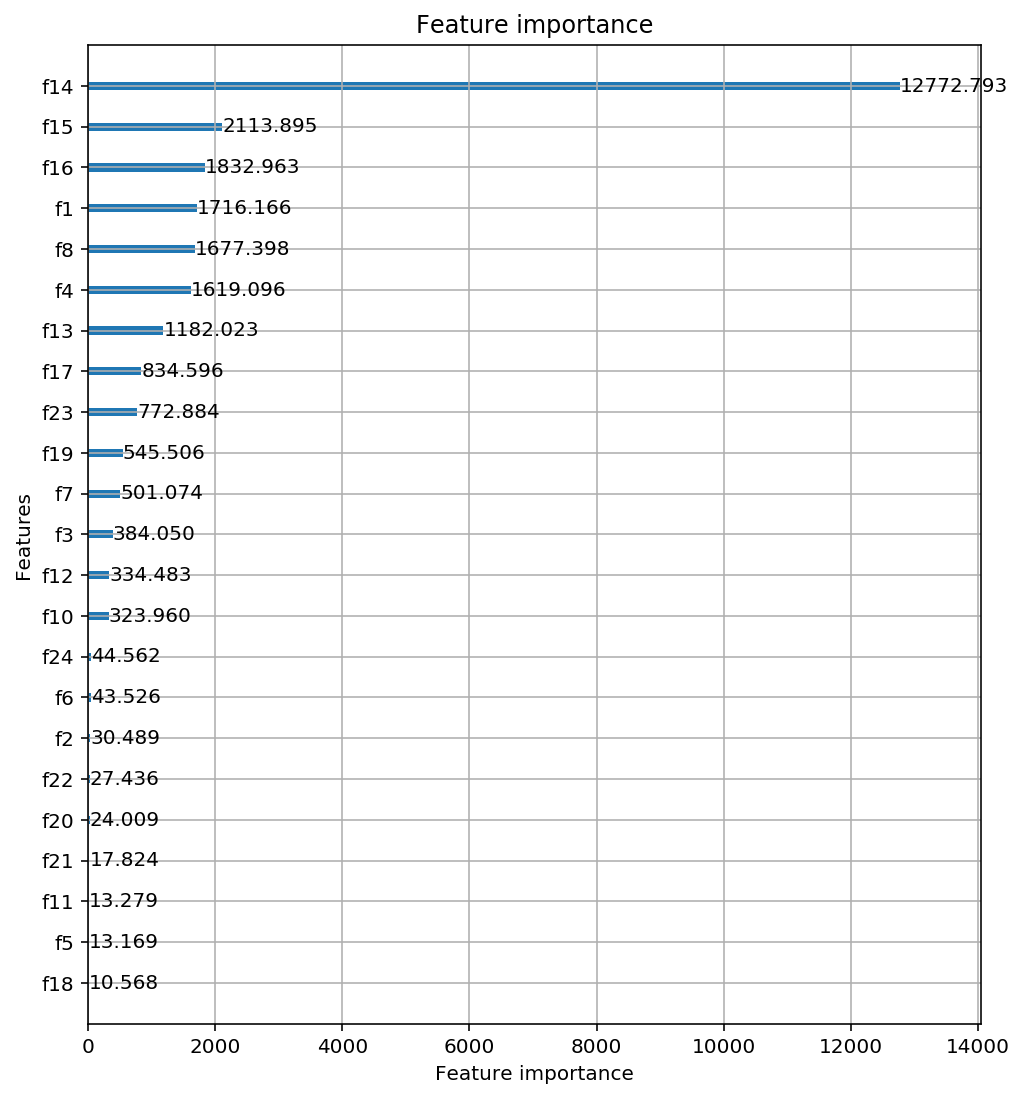

In [122]:
# Feature importance as per LGBM
lg=lgb.LGBMClassifier(random_state=1)
lg.fit(X,Y)
ax = lgb.plot_importance(lg, importance_type='gain',max_num_features=50)
fig = ax.figure
fig.set_size_inches(8, 9)

## Applying Models

In [8]:
def return_features(X,feats):
        X_mod=X[feats]
        return X_mod

def check_auc(model,X,Y, split,random_state=7):
    train_X, test_X, train_Y, test_Y = train_test_split(X,Y, test_size=split, random_state=random_state)
    model.fit(train_X,train_Y)
    ypred=model.predict_proba(test_X)[:,1]
    auc_score=roc_auc_score(test_Y,ypred)
    return auc_score

def predict_model(model,X,Y, split,random_state=7, test_default=False):

    if test_default:
        print("default test")
        model.fit(X,Y)
        ypred=model.predict_proba(X_test.values)[:,1]
        auc_score=roc_auc_score(Y_test.values,ypred)
        print("Model Report: ", type(model).__name__, " - AUC : ",auc_score)
        print("acc: ",accuracy_score(Y_test.values,model.predict(X_test.values)))
        confmat=confusion_matrix(Y_test.values,model.predict(X_test.values))
        print("Confusion Matrix:\n",confmat,"\n\n")


    else:
        train_X, test_X, train_Y, test_Y = train_test_split(X,Y, test_size=split, random_state=random_state)
        model.fit(train_X,train_Y)        
        ypred=model.predict_proba(test_X)[:,1]
        auc_score=roc_auc_score(test_Y,ypred)
        
        print("Model Report: ", type(model).__name__, " - AUC : ",auc_score)
        print("acc: ",accuracy_score(test_Y,model.predict(test_X)))
        confmat=confusion_matrix(test_Y,model.predict(test_X))
        print("Confusion Matrix:\n",confmat,"\n\n")


In [55]:
# Testing different models with default hyperparameters
models=[XGBClassifier(),AdaBoostClassifier(),GradientBoostingClassifier(),BalancedBaggingClassifier(),RandomForestClassifier(), BalancedRandomForestClassifier(), DecisionTreeClassifier(),lgb.LGBMClassifier()]
for lf in models:
    predict_model(lf,X,Y,0.2)


Model Report:  XGBClassifier  - AUC :  0.8455048174162467
acc:  0.9560573695453158
Confusion Matrix:
 [[  69  144]
 [   0 3064]] 


Model Report:  AdaBoostClassifier  - AUC :  0.8515534022236115
acc:  0.9554470552334452
Confusion Matrix:
 [[  67  146]
 [   0 3064]] 


Model Report:  GradientBoostingClassifier  - AUC :  0.8521302970127117
acc:  0.9557522123893806
Confusion Matrix:
 [[  69  144]
 [   1 3063]] 


Model Report:  BalancedBaggingClassifier  - AUC :  0.804014360313316
acc:  0.7601464754348489
Confusion Matrix:
 [[ 138   75]
 [ 711 2353]] 




/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Report:  RandomForestClassifier  - AUC :  0.7722407114576056
acc:  0.950259383582545
Confusion Matrix:
 [[  54  159]
 [   4 3060]] 


Model Report:  BalancedRandomForestClassifier  - AUC :  0.8724533887397491
acc:  0.7393957888312481
Confusion Matrix:
 [[ 176   37]
 [ 817 2247]] 


Model Report:  DecisionTreeClassifier  - AUC :  0.6669685213106313
acc:  0.9163869392737259
Confusion Matrix:
 [[  81  132]
 [ 142 2922]] 


Model Report:  LGBMClassifier  - AUC :  0.8787494330648818
acc:  0.9557522123893806
Confusion Matrix:
 [[  69  144]
 [   1 3063]] 




### Selected Features

In [10]:
# Models on 11 features: Sorted by Gain
X_8x=return_features(X,['f14','f8','f22','f4','f19','f7','f16','f15'])
X_9x=return_features(X,['f14','f8','f22','f4','f19','f7','f16','f15','f13'])
X_10x=return_features(X,['f14','f8','f22','f4','f19','f7','f16','f15','f13','f17'])
X_11x=return_features(X,['f14','f8','f22','f4','f19','f7','f16','f15','f13','f17','f1'])
X_12x=return_features(X,['f14','f8','f22','f4','f19','f7','f16','f15','f13','f17','f1','f11'])
X_15x=return_features(X,['f14','f8','f22','f4','f19','f7','f16','f15','f13','f17','f1','f11','f2','f23','f3'])
X_18x=return_features(X,['f14','f8','f22','f4','f19','f7','f16','f15','f13','f17','f1','f11','f2','f23','f3','f24','f12','f10'])
X_20x=return_features(X,['f14','f8','f22','f4','f19','f7','f16','f15','f13','f17','f1','f11','f2','f23','f3','f24','f12','f10','f18','f9'])

X_10l=return_features(X,['f14','f15','f16','f1','f8','f4','f13','f17','f23','f19'])
X_15l=return_features(X,['f14','f15','f16','f1','f8','f4','f13','f17','f23','f19','f7','f3','f12','f10','f24'])
X_18l=return_features(X,['f14','f15','f16','f1','f8','f4','f13','f17','f23','f19','f7','f3','f12','f10','f24','f6','f2','f22'])
X_20l=return_features(X,['f14','f15','f16','f1','f8','f4','f13','f17','f23','f19','f7','f3','f12','f10','f24','f6','f2','f22','f20','f21'])

lx=XGBClassifier()
lg=lgb.LGBMClassifier()

print('8:')
predict_model(lx,X_8x,Y,0.2)
print('9:')
predict_model(lx,X_9x,Y,0.2)
print('10:')
predict_model(lx,X_10x,Y,0.2)
print('11:')
predict_model(lx,X_11x,Y,0.2)
print('12:')
predict_model(lx,X_12x,Y,0.2)
print('15:')
predict_model(lx,X_15x,Y,0.2)
print('18:')
predict_model(lx,X_18x,Y,0.2)
print('20:')
predict_model(lx,X_20x,Y,0.2)
print('Plain:')
predict_model(lx,X,Y,0.2)

print('10:')
predict_model(lg,X_10l,Y,0.2)
print('15:')
predict_model(lg,X_15l,Y,0.2)
print('18:')
predict_model(lg,X_18l,Y,0.2)
print('20:')
predict_model(lg,X_20l,Y,0.2)
print('Plain:')
predict_model(lg,X,Y,0.2)

8:
Model Report:  XGBClassifier  - AUC :  0.8458901800708516
acc:  0.9560573695453158
Confusion Matrix:
 [[  69  144]
 [   0 3064]] 


9:
Model Report:  XGBClassifier  - AUC :  0.8460556638350555
acc:  0.9560573695453158
Confusion Matrix:
 [[  69  144]
 [   0 3064]] 


10:
Model Report:  XGBClassifier  - AUC :  0.8544685213106314
acc:  0.9560573695453158
Confusion Matrix:
 [[  69  144]
 [   0 3064]] 


11:
Model Report:  XGBClassifier  - AUC :  0.8547711420831342
acc:  0.9560573695453158
Confusion Matrix:
 [[  69  144]
 [   0 3064]] 


12:
Model Report:  XGBClassifier  - AUC :  0.8547711420831342
acc:  0.9560573695453158
Confusion Matrix:
 [[  69  144]
 [   0 3064]] 


15:
Model Report:  XGBClassifier  - AUC :  0.8491201779869818
acc:  0.9560573695453158
Confusion Matrix:
 [[  69  144]
 [   0 3064]] 


18:
Model Report:  XGBClassifier  - AUC :  0.8442659875703307
acc:  0.9560573695453158
Confusion Matrix:
 [[  69  144]
 [   0 3064]] 


20:
Model Report:  XGBClassifier  - AUC :  0.84426

### Undersampling and Oversampling for imbalanced data

In [15]:
# Undersampling - Random and TomekLinks and Oversampling
ros = TomekLinks(random_state=0,n_jobs=6)
x_tls, y_tls = ros.fit_resample(X.values, Y.values)

rus = RandomUnderSampler(random_state=42)
x_rus, y_rus = rus.fit_resample(X.values, Y.values)

sm = SMOTE(random_state=42)
x_os, y_os = sm.fit_resample(X_train.values, Y_train.values)

print(X_train.shape, " Original ---  Class-1: ", np.sum(Y_train==1), " : Class-0: ", np.sum(Y_train==0))
print(x_tls.shape, " Tomek Links Undersampling---  Class-1: ", np.sum(y_tls==1), " : Class-0: ", np.sum(y_tls==0))
print(x_rus.shape, " Undersampling ---  Class-1: ", np.sum(y_rus==1), " : Class-0: ", np.sum(y_rus==0))
print(x_os.shape, "  SMOTE Oversampling ----  Class-1: ", np.sum(y_os==1), " : Class-0: ", np.sum(y_os==0))

(13106, 24)  Original ---  Class-1:  12371  : Class-0:  735
(16013, 24)  Tomek Links Undersampling---  Class-1:  15065  : Class-0:  948
(1896, 24)  Undersampling ---  Class-1:  948  : Class-0:  948
(24742, 24)   SMOTE Oversampling ----  Class-1:  12371  : Class-0:  12371


In [115]:
# XGBoost on the resampled data
models=[XGBClassifier(random_state=777), GradientBoostingClassifier(random_state=777), RandomForestClassifier(random_state=777), BalancedRandomForestClassifier(random_state=777), lgb.LGBMClassifier(random_state=777)]

for lf in models:
    predict_model(lf,X, Y, 0.2)
    print("TomekLinks Undersampling")
    predict_model(lf,x_tls, y_tls, 0.2)
    print("Undersampling")
    predict_model(lf,x_rus, y_rus, 0.2)
    print("Oversampling: SMOTE")
    predict_model(lf,x_os, y_os, 0.2, test_default=True)
    print("--------------------------------------------------------------------------------------------")

Model Report:  XGBClassifier  - AUC :  0.8455048174162467
acc:  0.9560573695453158
Confusion Matrix:
 [[  69  144]
 [   0 3064]] 


TomekLinks Undersampling
Model Report:  XGBClassifier  - AUC :  0.8609071567134603
acc:  0.9622229160162348
Confusion Matrix:
 [[  70  121]
 [   0 3012]] 


Undersampling
Model Report:  XGBClassifier  - AUC :  0.8405664560470014
acc:  0.7526315789473684
Confusion Matrix:
 [[144  50]
 [ 44 142]] 


Oversampling: SMOTE
default test
Model Report:  XGBClassifier  - AUC :  0.8006993221294697
acc:  0.9050961245041196
Confusion Matrix:
 [[  61  152]
 [ 159 2905]] 


--------------------------------------------------------------------------------------------
Model Report:  GradientBoostingClassifier  - AUC :  0.8521272324985597
acc:  0.9557522123893806
Confusion Matrix:
 [[  69  144]
 [   1 3063]] 


TomekLinks Undersampling
Model Report:  GradientBoostingClassifier  - AUC :  0.8665269115510037
acc:  0.9622229160162348
Confusion Matrix:
 [[  70  121]
 [   0 3012]]

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Model Report:  RandomForestClassifier  - AUC :  0.7887620547478498
acc:  0.953793318763659
Confusion Matrix:
 [[  56  135]
 [  13 2999]] 


Undersampling
Model Report:  RandomForestClassifier  - AUC :  0.7591868972397738
acc:  0.6921052631578948
Confusion Matrix:
 [[144  50]
 [ 67 119]] 


Oversampling: SMOTE
default test
Model Report:  RandomForestClassifier  - AUC :  0.748706775027887
acc:  0.9023497101007019
Confusion Matrix:
 [[  40  173]
 [ 147 2917]] 


--------------------------------------------------------------------------------------------
Model Report:  BalancedRandomForestClassifier  - AUC :  0.8749708871155567
acc:  0.7488556606652426
Confusion Matrix:
 [[ 176   37]
 [ 786 2278]] 


TomekLinks Undersampling
Model Report:  BalancedRandomForestClassifier  - AUC :  0.8709455372228363
acc:  0.7524196066187949
Confusion Matrix:
 [[ 157   34]
 [ 759 2253]] 


Undersampling
Model Report:  BalancedRandomForestClassifier  - AUC :  0.8134630307061301
acc:  0.7105263157894737
Confus

#### Combination of Tomek Links undersampling and LGBMClassifier

In [132]:
# TomekLinks on optimal feature count
ros = TomekLinks(random_state=0,n_jobs=6)
x_tl11, y_tl11 = ros.fit_resample(X_11x.values, Y.values)

lf=XGBClassifier()
predict_model(lf,x_tl11, y_tl11, 0.2)
predict_model(lf,x_tls, y_tls, 0.2)

Model Report:  XGBClassifier  - AUC :  0.8415511028900745
acc:  0.9612862940992819
Confusion Matrix:
 [[  62  124]
 [   0 3017]] 


Model Report:  XGBClassifier  - AUC :  0.8609071567134603
acc:  0.9622229160162348
Confusion Matrix:
 [[  70  121]
 [   0 3012]] 




In [129]:
ros = TomekLinks(random_state=0,n_jobs=6)
x_tl18, y_tl18 = ros.fit_resample(X_18l.values, Y.values)

lf=lgb.LGBMClassifier()
predict_model(lf,x_tl18, y_tl18, 0.2)
predict_model(lf,x_tls, y_tls, 0.2)


Model Report:  LGBMClassifier  - AUC :  0.8832731899626625
acc:  0.9619107087105838
Confusion Matrix:
 [[  72  119]
 [   3 3009]] 


Model Report:  LGBMClassifier  - AUC :  0.8956495136382914
acc:  0.9625351233218857
Confusion Matrix:
 [[  73  118]
 [   2 3010]] 




Combination of Tomek Links undersampling and LGBMClassifier gives worse result in terms of accuracy and AUC as a reduction in features and samples is bad for the training.

In [116]:
# Trying XGBClassifier with non-default parameters

models = [XGBClassifier(random_state=1, n_estimators=500, max_depth=5, learning_rate=0.13, base_score=0.8),
          GradientBoostingClassifier(random_state=1, n_estimators=500, max_depth=5, learning_rate=0.13),
          BalancedRandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',max_depth=5, max_features='auto',min_samples_leaf=2, min_samples_split=2,min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,oob_score=False, random_state=42, verbose=0, warm_start=True),
          BalancedBaggingClassifier(random_state=777),
          lgb.LGBMClassifier(random_state=777,n_estimators=500, max_depth=5, learning_rate=0.13,base_score=0.8)]
     
for lf in models:
    predict_model(lf,X,Y,0.2)
    print("TomekLinks Undersampling")
    predict_model(lf,x_tls,y_tls,0.2)
    print("Oversampling")
    predict_model(lf,x_os,y_os, 0.2, test_default=True)
    print("----------------------------------------------------------------------------------------------------------")
    
    

Model Report:  XGBClassifier  - AUC :  0.8907148285710783
acc:  0.9566676838571865
Confusion Matrix:
 [[  76  137]
 [   5 3059]] 


TomekLinks Undersampling
Model Report:  XGBClassifier  - AUC :  0.8913595182967954
acc:  0.9615985014049329
Confusion Matrix:
 [[  75  116]
 [   7 3005]] 


Oversampling
default test
Model Report:  XGBClassifier  - AUC :  0.8800319322374632
acc:  0.9533109551418981
Confusion Matrix:
 [[  76  137]
 [  16 3048]] 


----------------------------------------------------------------------------------------------------------
Model Report:  GradientBoostingClassifier  - AUC :  0.8779036271589502
acc:  0.954226426609704
Confusion Matrix:
 [[  72  141]
 [   9 3055]] 


TomekLinks Undersampling
Model Report:  GradientBoostingClassifier  - AUC :  0.8899723966264089
acc:  0.9625351233218857
Confusion Matrix:
 [[  77  114]
 [   6 3006]] 


Oversampling
default test
Model Report:  GradientBoostingClassifier  - AUC :  0.864258877897498
acc:  0.9539212694537686
Confusion M

/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/imblearn/ensemble/_forest.py:408: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Model Report:  BalancedRandomForestClassifier  - AUC :  0.8650198507888169
acc:  0.7208866687480487
Confusion Matrix:
 [[ 157   34]
 [ 860 2152]] 


Oversampling
default test


/Users/subhayuchakravarty/anaconda3/lib/python3.7/site-packages/imblearn/ensemble/_forest.py:408: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn("Warm-start fitting without increasing n_estimators does not "


Model Report:  BalancedRandomForestClassifier  - AUC :  0.8411938121330244
acc:  0.7058285016783643
Confusion Matrix:
 [[ 174   39]
 [ 925 2139]] 


----------------------------------------------------------------------------------------------------------
Model Report:  BalancedBaggingClassifier  - AUC :  0.8138874587822847
acc:  0.7583155324992371
Confusion Matrix:
 [[ 139   74]
 [ 718 2346]] 


TomekLinks Undersampling
Model Report:  BalancedBaggingClassifier  - AUC :  0.825326964393734
acc:  0.7633468623165782
Confusion Matrix:
 [[ 129   62]
 [ 696 2316]] 


Oversampling
default test
Model Report:  BalancedBaggingClassifier  - AUC :  0.7775829257529512
acc:  0.90051876716509
Confusion Matrix:
 [[  85  128]
 [ 198 2866]] 


----------------------------------------------------------------------------------------------------------
Model Report:  LGBMClassifier  - AUC :  0.8828313659152478
acc:  0.9545315837656393
Confusion Matrix:
 [[  72  141]
 [   8 3056]] 


TomekLinks Undersampling

### ROC Curve XGB vs LGBM - Default Hyperparameters

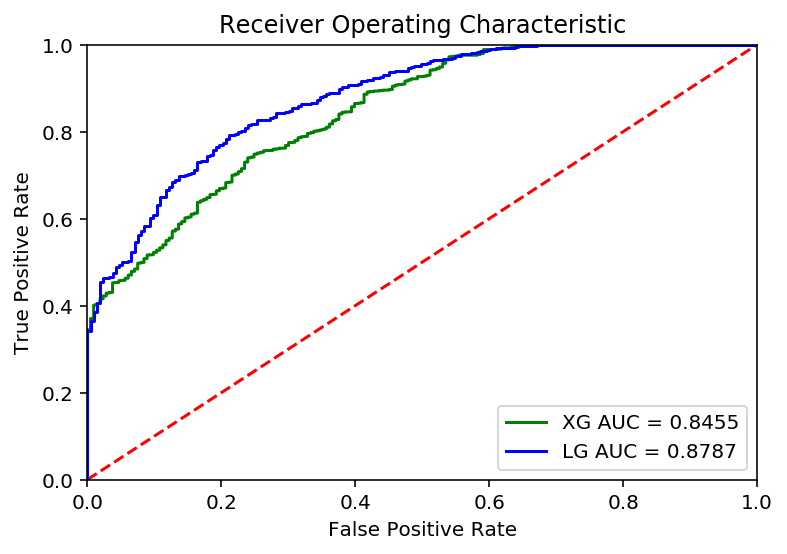

In [135]:
lf=XGBClassifier(random_state=1)
lf.fit(X_train,Y_train)
y_prob=lf.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(Y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'g', label = 'XG AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

lf=lgb.LGBMClassifier()
lf.fit(X_train,Y_train)
y_prob=lf.predict_proba(X_test)[:,1]

fpr, tpr, threshold = roc_curve(Y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'LG AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.show()

### ROC Curve XGB vs LGBM - Non-Default Hyperparameters

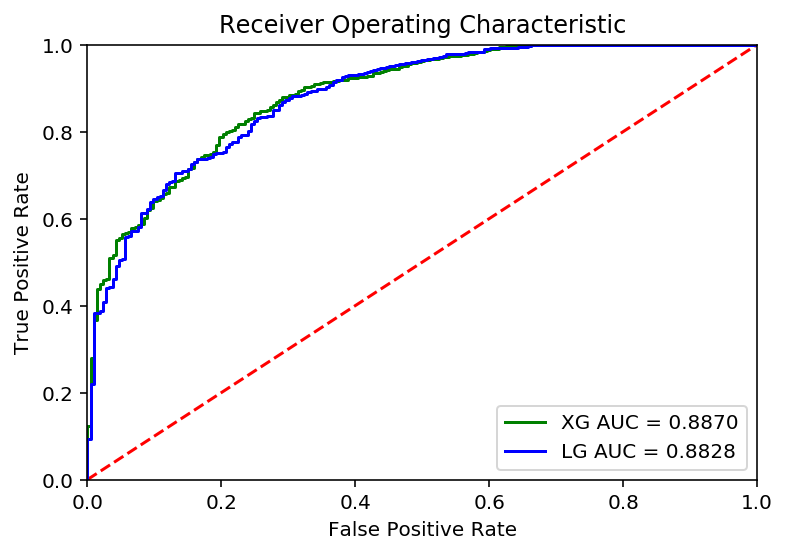

In [137]:
lf=XGBClassifier(random_state=1, n_estimators=500, max_depth=5, learning_rate=0.15)
lf.fit(X_train.values,Y_train.values)
y_prob=lf.predict_proba(X_test.values)[:,1]

fpr, tpr, threshold = roc_curve(Y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'g', label = 'XG AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

lf=lgb.LGBMClassifier(random_state=1, n_estimators=500, max_depth=5, learning_rate=0.13)
lf.fit(X_train.values,Y_train.values)
y_prob=lf.predict_proba(X_test.values)[:,1]

fpr, tpr, threshold = roc_curve(Y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'LG AUC = %0.4f' % roc_auc)
plt.legend(loc = 'lower right')
plt.show()

## Feature Selection

## Hyperparameter tuning

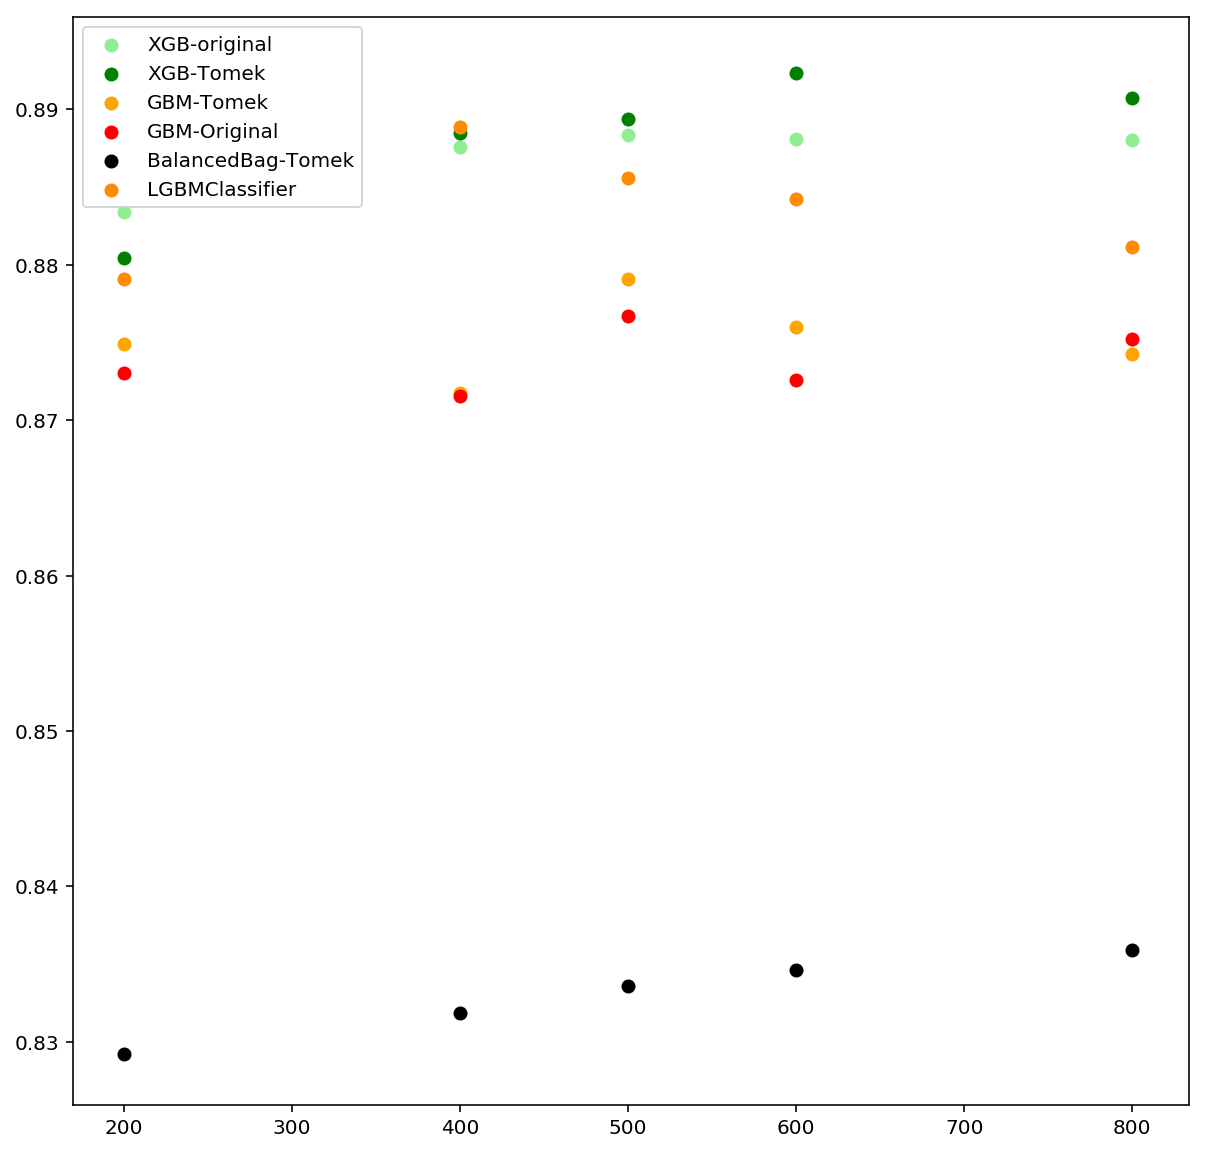

In [206]:
# Varying the number of trees in XGBoost

# X_train=X_train.values
# Y_train=Y_train.values
# X_test=X_test.values
# Y_test=Y_test.values

trees=[200,400,500,600,800]
plt.figure(figsize=(10,10))
for i in trees:
    xgb=XGBClassifier(random_state=int(i/2), n_estimators=i, learning_rate=0.1, max_depth=5)
    plt.scatter(i,check_auc(xgb,X_train,Y_train,X_test,Y_test),c='lightgreen')
    plt.scatter(i,check_auc(xgb,x_tls, y_tls,X_test,Y_test),c='green')    
    gbm=GradientBoostingClassifier(random_state=int(i/2), n_estimators=i, learning_rate=0.1, max_depth=5)
    plt.scatter(i,check_auc(gbm,X_train,Y_train,X_test,Y_test),c='orange')
    plt.scatter(i,check_auc(gbm,x_tls, y_tls,X_test,Y_test),c='red')
    bb=BalancedBaggingClassifier(random_state=7,sampling_strategy=0.9, n_estimators=i)
    plt.scatter(i,check_auc(bb,x_tls, y_tls,X_test,Y_test),c='black')
    lgmodel=lgb.LGBMClassifier(random_state=7,n_estimators=i, learning_rate=0.1, max_depth=5)
    plt.scatter(i,check_auc(lgmodel,x_tls, y_tls,X_test,Y_test),c='darkorange')

plt.legend({'XGB-original':'lightgreen','XGB-Tomek':'green','GBM-Tomek':'orange','GBM-Original':'red','BalancedBag-Tomek':'black','LGBMClassifier':'darkorange'})

plt.savefig('200-800.png')   

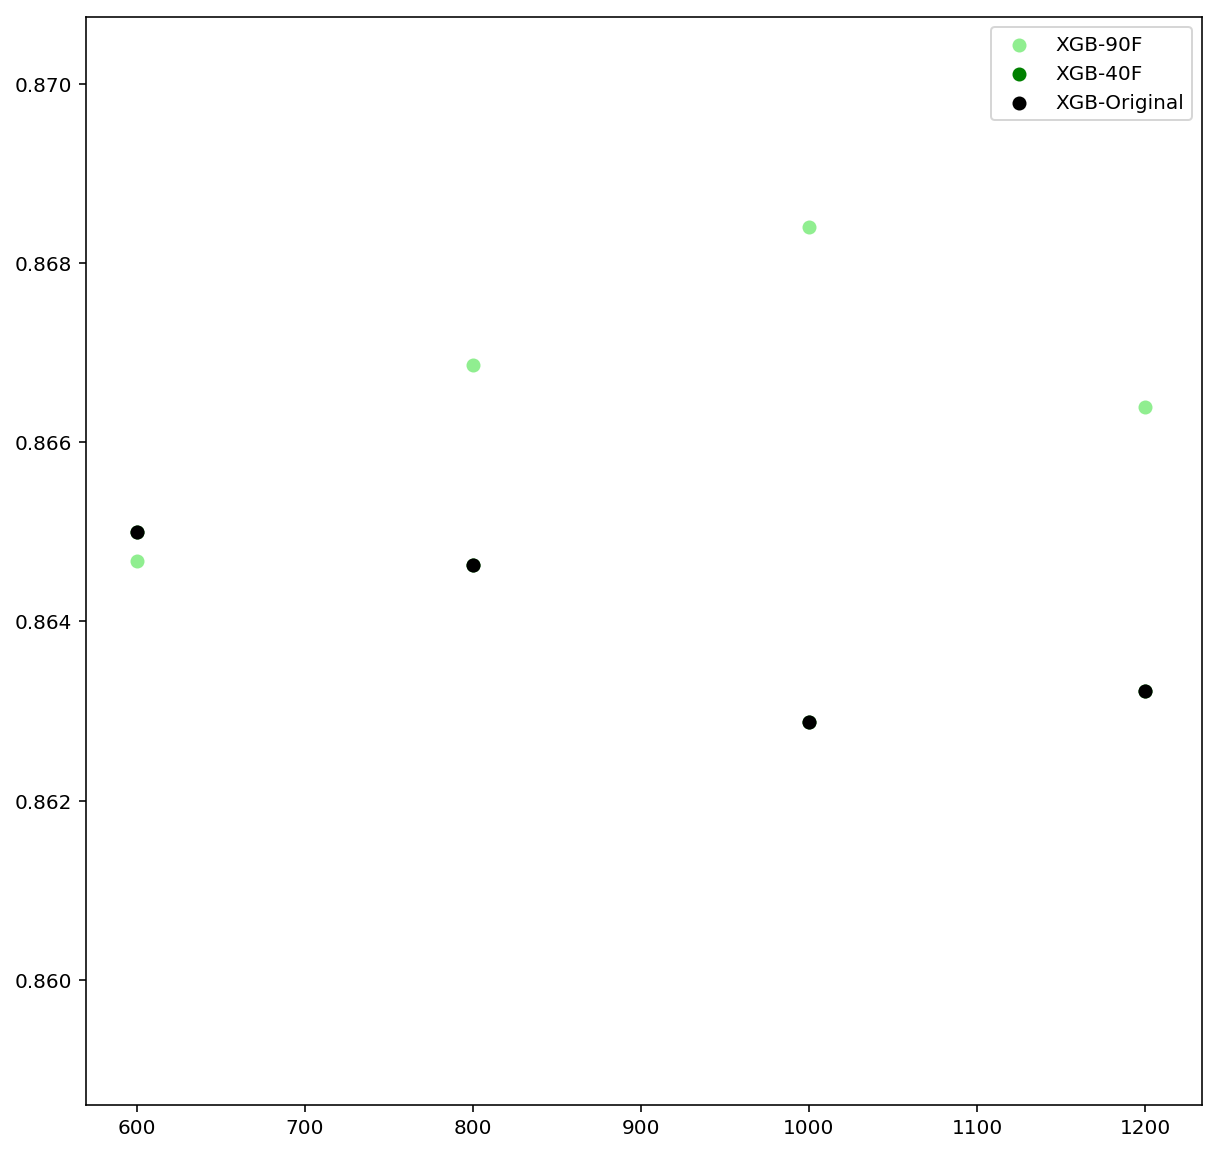

In [31]:
# Varying the number of trees in XGBoost

# X_strain=X_strain.values
# Y_strain=Y_strain.values
# X_stest=X_stest.values
# Y_stest=Y_stest.values

trees=[400, 600,800,1000]
plt.figure(figsize=(10,10))
for i in trees:
    xgb1=XGBClassifier(random_state=1, n_estimators=i)
    plt.scatter(i,check_auc(xgb1,X_otrain,Y_otrain,X_otest,Y_otest),c='lightgreen')
    
    xgb3=XGBClassifier(random_state=1, n_estimators=i)
    plt.scatter(i,check_auc(xgb3,X_strain,Y_strain,X_stest,Y_stest),c='green')

    xgb2=XGBClassifier(random_state=1, n_estimators=i)
    plt.scatter(i,check_auc(xgb2,X_train_t,Y_train_t,X_test_t,Y_test_t),c='black')


plt.legend({'XGB-90F':'lightgreen','XGB-40F':'green','XGB-Original':'yellow'})

plt.savefig('400-1000_F.png')   

In [143]:
def predict_GridCV(model,params,X,Y,split=0.2, test_default=False):
    
    if test_default:
        train_X, test_X, train_Y, test_Y = train_test_split(X,Y, test_size=split, random_state=7)
        clf=GridSearchCV(model, params, cv=3, scoring='roc_auc', verbose=1,n_jobs=-1)
        clf.fit(train_X,train_Y)
        ypred=clf.predict_proba(X_test)[:,1]
        auc_score=roc_auc_score(Y_test,ypred)

        print(clf.best_params_)
        print(clf.best_score_)
        print()
        print()
        print("AUC: ",auc_score)
        print("acc: ",accuracy_score(Y_test,clf.predict(X_test)))
        confmat=confusion_matrix(Y_test,clf.predict(X_test))
        print("\nConfusion Matrix:\n",confmat,"\n\n")


    else:
        train_X, test_X, train_Y, test_Y = train_test_split(X,Y, test_size=split, random_state=7)
        clf=GridSearchCV(model, params, cv=3, scoring='roc_auc', verbose=1,n_jobs=-1)
        clf.fit(train_X,train_Y)
        ypred=clf.predict_proba(test_X)[:,1]
        auc_score=roc_auc_score(test_Y,ypred)

        print(clf.best_params_)
        print(clf.best_score_)
        print()
        print()
        print("AUC: ",auc_score)
        print("acc: ",accuracy_score(test_Y,clf.predict(test_X)))
        confmat=confusion_matrix(test_Y,clf.predict(test_X))
        print("\nConfusion Matrix:\n",confmat,"\n\n")

## Tuning for Original Dataset

In [151]:
# Tuning XGB
parameters={
                "learning_rate":[.13], #[0.12,0.13,0.14], #[0.12,0.1,0.09]
                "n_estimators":[500], #[100,300,500,1000]
                "max_depth":[5], #[3,2,1]
                "eval_metric":['auc'],
#                 "scale_pos_weight":[1], #[0.5,1,2]
#                 "min_child_weight":[2],
#                 "gamma":[0.1],
#                 "subsample":[0.8], #[i/10.0 for i in range(6,10)],
#                 "colsample_bytree":[0.8,1], #[i/10.0 for i in range(6,10)]
                "base_score":[.8]
                
}


lf=XGBClassifier(random_state=1)
predict_GridCV(lf,parameters,X,Y) #max_depth=3 is best, min_child=1 .8896, .89012, .8941
predict_GridCV(lf,parameters,X_ohe,Y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   11.3s finished


{'base_score': 0.8, 'eval_metric': 'auc', 'learning_rate': 0.13, 'max_depth': 5, 'n_estimators': 500}
0.8389025939448044


AUC:  0.8907148285710783
acc:  0.9566676838571865

Confusion Matrix:
 [[  76  137]
 [   5 3059]] 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   32.9s finished


{'base_score': 0.8, 'eval_metric': 'auc', 'learning_rate': 0.13, 'max_depth': 5, 'n_estimators': 500}
0.838635516617838


AUC:  0.8853963642604101
acc:  0.9566676838571865

Confusion Matrix:
 [[  78  135]
 [   7 3057]] 




In [150]:
# Tuning LGBM
parameters={
                "learning_rate":[.13], #[0.1,0.15,0.08],
                "n_estimators":[300],
                "max_depth":[5], #[3,2,4]
                
}


lf=lgb.LGBMClassifier(random_state=1)
predict_GridCV(lf,parameters,X,Y) #.88264
predict_GridCV(lf,parameters,X_ohe,Y)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.8s finished


{'learning_rate': 0.13, 'max_depth': 5, 'n_estimators': 300}
0.8366611496999127


AUC:  0.880615722183405
acc:  0.9554470552334452

Confusion Matrix:
 [[  72  141]
 [   5 3059]] 


Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    2.4s finished


{'learning_rate': 0.13, 'max_depth': 5, 'n_estimators': 300}
0.8395989056049388


AUC:  0.8833354784932397
acc:  0.9557522123893806

Confusion Matrix:
 [[  74  139]
 [   6 3058]] 




In [301]:
# Tuning GBM
parameters={
                "learning_rate":[0.15,0.14,.16], #[0.1,0.15,0.08],
                "n_estimators":[500,450,550],
                "max_depth":[4,5] #[3,2,4]
                
}


lf=GradientBoostingClassifier(random_state=1)
predict_GridCV(lf,parameters,X_train,Y_train,X_test,Y_test) # .88086

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  5.8min finished


{'learning_rate': 0.15, 'max_depth': 4, 'n_estimators': 500}
0.8493059365252252


0.8808632588606854
acc:  0.9584986267927983

Confusion Matrix:
 [[  80  126]
 [  10 3061]] 




In [295]:
# Tuning BalancedRandomForestClassifier
parameters={
                "sampling_strategy":[0.5,0.3,0.4],
                "n_estimators":[500,550,450],
                "warm_start":[True,False],
                "criterion":['entropy']
                
}


lf=BalancedRandomForestClassifier(random_state=1)
predict_GridCV(lf,parameters,X_train,Y_train,X_test,Y_test)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  5.8min finished


{'criterion': 'entropy', 'n_estimators': 500, 'sampling_strategy': 0.5, 'warm_start': True}
0.8417235300035552


0.8615722401545305
acc:  0.9148611534940494

Confusion Matrix:
 [[ 109   97]
 [ 182 2889]] 




## Tuning for Tomek Links Training set:

In [318]:
# Tuning XGB
parameters={
                "learning_rate":[.13], #[0.12,0.13,0.14], #[0.12,0.1,0.09]
                "n_estimators":[600,500,650],
                "max_depth":[4,5], #[3,2,1]
#                 "eval_metric":['auc'],
#                 "scale_pos_weight":[1], #[0.5,1,2]
#                 "min_child_weight":[2],
#                 "gamma":[0.1],
#                 "subsample":[0.8], #[i/10.0 for i in range(6,10)],
#                 "colsample_bytree":[0.8,1,0.9], #[i/10.0 for i in range(6,10)]
                
}


lf=XGBClassifier(random_state=1)
predict_GridCV(lf,parameters,x_tls,y_tls,X_test,Y_test) # .886448


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  2.1min finished


{'learning_rate': 0.13, 'max_depth': 4, 'n_estimators': 600}
0.8545722963700999


0.886448707451164
acc:  0.9569728410131217

Confusion Matrix:
 [[  75  131]
 [  10 3061]] 




In [146]:
# LGBM with Tomek Links
tom = TomekLinks(random_state=0,n_jobs=6)
x_tom, y_tom = tom.fit_sample(X_train.values, Y_train.values)
parameters={
                "learning_rate":[0.13], #[.008,.01,.005,.0001], #[0.1,0.15,0.08],
                "n_estimators":[500], #[4000,5000],
                "max_depth":[4], #[3,2,4]
                "num_leaves":[8]
                
}


lf=lgb.LGBMClassifier(random_state=1)
predict_GridCV(lf,parameters,x_tom,y_tom,test_default=True)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    3.0s finished


{'learning_rate': 0.13, 'max_depth': 4, 'n_estimators': 500, 'num_leaves': 8}
0.8327576017190789


AUC:  0.8624217016634181
acc:  0.9551418980775099

Confusion Matrix:
 [[  73  140]
 [   7 3057]] 




In [149]:
# Tuning GBM
parameters={
                "learning_rate":[0.15,0.14,.13], #[0.1,0.15,0.08],
                "n_estimators":[500],
                "max_depth":[4] #[3,2,4]
                
}


lf=GradientBoostingClassifier(random_state=1)
predict_GridCV(lf,parameters,x_tls,y_tls) 

Fitting 3 folds for each of 3 candidates, totalling 9 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of   9 | elapsed:   29.1s finished


{'learning_rate': 0.13, 'max_depth': 4, 'n_estimators': 500}
0.8503781403365012


AUC:  0.8941563588577627
acc:  0.9597252575710271

Confusion Matrix:
 [[  75  116]
 [  13 2999]] 




In [ ]:
# Tuning BalancedRandomForestClassifier
parameters={
                "sampling_strategy":[0.9,.5,.2],
                "n_estimators":[500,1000,2000],
                "warm_start":[True]
                
}


lf=BalancedRandomForestClassifier(random_state=1)
predict_GridCV(lf,parameters,x_tls,y_tls,X_test,Y_test)

In [121]:
Xn_train=X_train.copy()
Xn_train['int1']=(Xn_train.f19*Xn_train.f8)/1e8
ros = TomekLinks(random_state=0,n_jobs=6)
x_tns, y_tns = ros.fit_sample(Xn_train, Y_train.values)

lf=XGBClassifier(random_state=777,max_depth=6,n_estimators=12000,learning_rate=0.04,
                 colsample_bytree=0.6, gamma=0.1)

predict_model(lf,x_tks,y_tks, X_test.values, Y_test.values)

Prediction results for Model:  XGBClassifier  : AUC :  0.8661594557940151
acc:  0.9599186164801627
Confusion Matrix:
 [[  98  183]
 [  14 4620]] 




## Removing Outliers

In [193]:
# Outlier removal from X,Y
X=df.iloc[:,2:]
Y=df.iloc[:,1]


print(X.shape)
outliers=set()
X_out=X.copy()
Y_out=Y.copy()
for index, row in X_out.iterrows():
    outlier_row_count=0
    for i in X_out.columns:
        cmean=X_out[i].mean()
        cstd=X_out[i].std()
        if np.abs(row[i]-cmean) > (2*cstd):
            outlier_row_count+=1
    if outlier_row_count>5 and Y_out[index]==1:
#             print(outlier_row_count)
#             print(index)
            outliers.add(index)



print(outliers)
X_out.drop(outliers, axis=0, inplace=True)
Y_out.drop(outliers, axis=0, inplace=True)
print(X_out.shape)

(16383, 24)
{4667}
(16382, 24)


In [196]:
# Testing out optimal hyperparameters on outlier-less data

ros = TomekLinks(random_state=0,n_jobs=6)
x_os, y_os = ros.fit_sample(X_out.values, Y_out.values)
# x_ts, y_ts = ros.fit_sample(X_train.values, Y_train.values)

lf=XGBClassifier(random_state=777,max_depth=5,n_estimators=600,learning_rate=0.15,
                 colsample_bytree=0.98, base_score=0.7)

print("Without Outliers")
predict_model(lf,X_out, Y_out, 0.2)
print("With Outliers")
predict_model(lf,X, Y, 0.2)

Without Outliers
Model Report:  XGBClassifier  - AUC :  0.8825427665371386
acc:  0.9575831553249924
Confusion Matrix:
 [[  71  133]
 [   6 3067]] 


With Outliers
Model Report:  XGBClassifier  - AUC :  0.8894744664680863
acc:  0.9557522123893806
Confusion Matrix:
 [[  76  137]
 [   8 3056]] 




#### Plotting for eye-balling the optimal feature and testing GridSearchCV results:

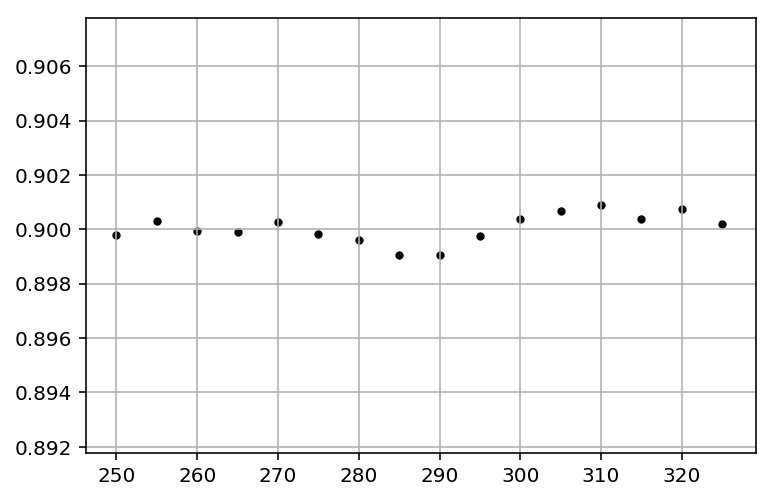

In [42]:
for i in np.arange(250,330,5):
#     plt.scatter(i,check_auc(lgb.LGBMClassifier(random_state=7,learning_rate=0.1,n_estimators=i,max_depth=5),X_18l,Y,0.2),s=10,c='red')
    plt.scatter(i,check_auc(XGBClassifier(random_state=7,learning_rate=0.15,n_estimators=i,max_depth=5,base_score=0.8),X_10x,Y,0.2),s=10,c='black')
plt.grid()
plt.savefig('estimators_curve.png')
plt.show()

In [179]:
check_auc(lgb.LGBMClassifier(random_state=7,learning_rate=0.11,n_estimators=400, max_depth=5),X_18l,Y,0.2)

0.8888424104242513

In [182]:
predict_model(lgb.LGBMClassifier(random_state=7,learning_rate=0.1,n_estimators=400, max_depth=5),X,Y,0.2)

Model Report:  LGBMClassifier  - AUC :  0.8837568491891296
acc:  0.9551418980775099
Confusion Matrix:
 [[  71  142]
 [   5 3059]] 




In [21]:
predict_model(XGBClassifier(random_state=7,learning_rate=.15,n_estimators=300,max_depth=5, base_score=0.8),x_tls,y_tls,0.2)


Model Report:  XGBClassifier  - AUC :  0.900378773949178
acc:  0.9560573695453158
Confusion Matrix:
 [[  79  134]
 [  10 3054]] 




In [41]:
check_auc(XGBClassifier(random_state=7,learning_rate=.15,n_estimators=310,max_depth=5,base_score=0.8),X_10x,Y,0.2)

0.9009104671545373

In [208]:
lx=XGBClassifier(random_state=7,learning_rate=.15,n_estimators=300,max_depth=5,base_score=.8)

print('8:')
predict_model(lx,X_8x,Y,0.2)
print('9:')
predict_model(lx,X_9x,Y,0.2)
print('10:')
predict_model(lx,X_10x,Y,0.2)
print('11:')
predict_model(lx,X_11x,Y,0.2)
print('12:')
predict_model(lx,X_12x,Y,0.2)
print('15:')
predict_model(lx,X_15x,Y,0.2)
print('18:')
predict_model(lx,X_18x,Y,0.2)
print('20:')
predict_model(lx,X_20x,Y,0.2)
print('Plain:')
predict_model(lx,X,Y,0.2)

8:
Model Report:  XGBClassifier  - AUC :  0.8863417668762795
acc:  0.9569728410131217
Confusion Matrix:
 [[  78  135]
 [   6 3058]] 


9:
Model Report:  XGBClassifier  - AUC :  0.8921359970090342
acc:  0.9557522123893806
Confusion Matrix:
 [[  77  136]
 [   9 3055]] 


10:
Model Report:  XGBClassifier  - AUC :  0.900378773949178
acc:  0.9560573695453158
Confusion Matrix:
 [[  79  134]
 [  10 3054]] 


11:
Model Report:  XGBClassifier  - AUC :  0.8938705120190245
acc:  0.957277998169057
Confusion Matrix:
 [[  78  135]
 [   5 3059]] 


12:
Model Report:  XGBClassifier  - AUC :  0.8870320486890008
acc:  0.9575831553249924
Confusion Matrix:
 [[  78  135]
 [   4 3060]] 


15:
Model Report:  XGBClassifier  - AUC :  0.8924746258228221
acc:  0.9560573695453158
Confusion Matrix:
 [[  76  137]
 [   7 3057]] 


18:
Model Report:  XGBClassifier  - AUC :  0.8822299550129324
acc:  0.9563625267012511
Confusion Matrix:
 [[  74  139]
 [   4 3060]] 


20:
Model Report:  XGBClassifier  - AUC :  0.8891733

### Best results for 10 features and XGBoost

## Predicting on Test Data

In [218]:
testX=test.iloc[:,1:]
ids=test.iloc[:,0].astype(int).values

testX10=return_features(testX,['f14','f8','f22','f4','f19','f7','f16','f15','f13','f17'])

lf_final=XGBClassifier(random_state=7,learning_rate=.15,n_estimators=300,max_depth=5,base_score=0.8)
lf_final.fit(X_10x,Y)
ypred=lf_final.predict_proba(testX10)[:,1]
output=np.column_stack((ids,ypred))
x=pd.DataFrame(output)
x=x.rename(columns={0:'Id',1:'Y'})

In [219]:
x.Id=x.Id.astype(int)
x.to_csv('submission.csv', index=False)

### <div align="center">The End</div>